<h1><center>SAP IES AICOE TAKE-HOME TEST </center></h1>
<h2><center> Machine Learning </center></h2>

# Please choose <font color="red">ONLY 1</font> part of your interest: either Part A or B

# <font color="blue">Part A</font>

## Guideline:

- File to use: **contract_dataset_v20220109.csv**
- Train a **MULTI-CLASS CLASSIFICATION MODEL**. Your final model should be able to take in a test clause (column `provision`) and predict its provision type (column `label`). 
- Perform your own train-test split.
- Choose your own evaluation metrics and explain your choice(s).
- You may refer to, and/or copy code blocks from any public Github repositories, Kaggle kernels or tutorials online. However, please add a comment indicating the source.
- You are free to conduct exploratory data analysis, write unit tests or any other additional steps as you find neccesary.
- The purpose is NOT to train the best-performing model. It is to help us assess your ability to learn and apply NLP modelling techniques.

## Answer:

In [186]:
# Set Up Notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# Read Input File
csv = pd.read_csv("../data/contract_dataset_v20220109.csv")
csv = csv.drop(columns=['source', 'Contract_Dates', 'Passwords'])

#### Exploratory Data Analysis
The count plot is a quick way to visualise the breakdown of the labels. We observe that most contracts are about 'governing laws'. We also observe that there is no clear label that dominates the dataset, so there is no need for special techniques like oversampling, class-weighting, or threshold finetuning that are conventionally applied for imbalanced datasets.

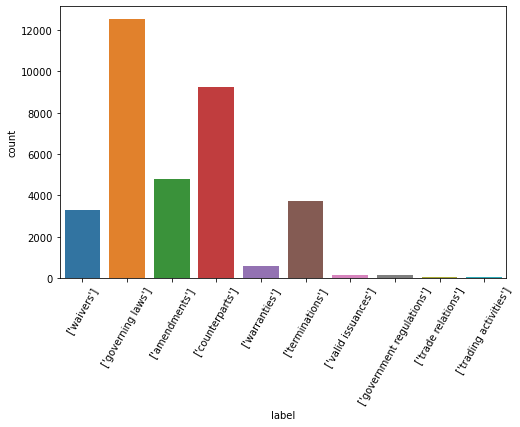

In [20]:
#Visualise Count Plot
plt.figure(figsize=(8,5))
sns.countplot(x=csv["label"])
plt.xticks(rotation=60)
plt.show()

#### Supervised Learning vs NLP
It is well known that conventional supervised learning methods do not perform well on NLP. For example, if we were to run a
decision tree classifier (where each word is a feature used to predict the label of the contract), we would run into several problems. First, there would be an enormous amount of features, implying a gigantic (and likely overfitted) tree. Second, the same words might suggest different classifications under different context. These will likely lead to poor classification performance. NLP techniques are therefore important in working with such datasets. 

#### Data Cleaning
As text data often contain numerous typography errors and formatting issues, it is customary to perform data cleaning before performing classification. In our context, contractual data is unlikely to contain typography errors, so we should not need to rectify spelling issues. Neither do we need to lemmatise or stem our words because contracts are typically written in accurate English and because we want to capture the grammatical differences between certain words ("owe" for example will frequently be used differently from "owing"). 

However, we might want to correct errors that arise from formatting. We do so by defining a list of valid characters and removing characters that are not in this list. Note that punctuations have also been removed because they are unlikely to add much value in determining the label of the contract.

In [21]:
valid = "abcdefghijklmnopqrstuvwxyz " #define list of valid characters

def clean_text(data):
    """
    This function takes in a dataframe with the column "label". It cleans the text for each row in that column, and replaces the
    column "label" with the cleaned column before returning the dataframe.
    """
    output = [] #define variable to store cleaned text
    
    for line in data["provision"]:
        line = line.lower()
        cleaned_line = ''.join(c for c in line if c in valid) #join valid characters together
        output.append(cleaned_line)
    data["provision"] = output #update dataframe column with cleaned output array
    
    return data

In [22]:
clean_csv = clean_text(csv)
clean_csv.head()

,provision,label
0,borrower and any endorsers or guarantors hereo...,['waivers']
1,no failure to exercise and no delay in exercis...,['waivers']
2,until the discharge of senior lender claims ha...,['waivers']
3,neither party shall be deemed to have waived a...,['waivers']
4,no waiver of the provisions hereof shall be va...,['waivers']


#### TF-IDF
The Term Frequency - Inverse Document Frequency is a classic NLP technique that uses the frequency of words to determine how important the words are. We can use TF-IDF to select words that are important and use them as features to perform classification. Another advantage of TF-IDF is that we can visualise which words are more important (and how much more important), which provides us valuable insight into whether our model makes intuitive sense. 

To quantify the accuracy of our model, we first perform a train-test split. As the data labels tend to be bunched together (the following row will likely have the same label as the current row), we shuffle our dataset for a fairer split.

In [37]:
#Perform Train-Test Split
shuffled = shuffle(clean_csv)
shuffled = pd.get_dummies(shuffled, prefix=['lab'], columns=['label']) #perform encoding for multi-class classification
X = shuffled['provision']
y = shuffled.drop('provision', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [69]:
#Train TF-IDF Model
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 1)) #initialise TF-IDF model
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [70]:
#Train Classifier Model
clf = MultiOutputClassifier(LogisticRegression(class_weight='balanced', max_iter=5000)) #initialise logistic classifier
clf.fit(X_train_vec, y_train)
y_pred = np.transpose(np.array(clf.predict_proba(X_test_vec))[:,:,1])

In [75]:
#Test ROC AUC Score
auc = roc_auc_score(y_test, y_pred)
print("The ROC AUC score is", round(auc, 5))

The ROC AUC score is 0.99954


In [193]:
#Test Accuracy Score
accuracy = clf.score(X_test_vec, y_test)
print("The classification accuracy is", round(accuracy, 5))

The classification accuracy is 0.96339


In [151]:
#Test Confusion Matrix
y_test_cm = y_test.to_numpy()
y_pred_cm = np.array(clf.predict(X_test_vec))
cm = multilabel_confusion_matrix(y_test_cm, y_pred_cm)
print(cm)

[[[5850   79]
  [  18  963]]

 [[5073    9]
  [   8 1820]]

 [[4369    4]
  [   6 2531]]

 [[6885    0]
  [   1   24]]

 [[6122   52]
  [   5  731]]

 [[6899    0]
  [   0   11]]

 [[6902    0]
  [   0    8]]

 [[6890    0]
  [   0   20]]

 [[6177   82]
  [  16  635]]

 [[6772   25]
  [   2  111]]]


In [89]:
#Test Classification Report
print(classification_report(y_test_cm, y_pred_cm))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       981
           1       1.00      1.00      1.00      1828
           2       1.00      1.00      1.00      2537
           3       1.00      0.96      0.98        25
           4       0.93      0.99      0.96       736
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00        20
           8       0.89      0.98      0.93       651
           9       0.82      0.98      0.89       113

   micro avg       0.96      0.99      0.98      6910
   macro avg       0.96      0.99      0.97      6910
weighted avg       0.97      0.99      0.98      6910
 samples avg       0.98      0.99      0.98      6910



C:\Users\Tan Ning Xuan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the results above, we observe that the TF-IDF logistic classifier is highly efficient with an ROC AUC score of close to 1. On the whole, we also observe that the classification accuracy and overall F1-score (which accounts for both the precision and recall) are all very high. Diving into the confusion matrix, we also observe that most categories are very well-classified. From the classification report, the classifier seemed to have slightly more difficulty labelling contracts for "waivers" and "warranties", perhaps because these contracts constitute a small proportion of the overall contract database, so their features were more easily dominated by other classes. To understand what went on behind the classification, we need understand which features played a larger role in which classification.

#### Feature Importance
As mentioned earlier, understanding the feature importance is a one huge benefit of the TF-IDF algorithm. The table below shows some of the features and their score (an indicator of importance) for predicting each class. We can go one step further and plot the most important features of each class, which can give us some insight into which features are important for which class. The results are very sensible, and words that were found to be the most important are often the most closely related to the label of each class.

In [181]:
#Extract Feature Importance
feat_impts = [vectorizer.get_feature_names_out()]

for c in clf.estimators_:
    feat_impts.append(c.coef_.flatten())

df_feat_impts = pd.DataFrame(np.transpose(np.array(feat_impts)), columns=['Feature']+['Amendments']+['Counterparts']+ 
                                                                           ['Governing Laws']+['Government Regulations']+
                                                                           ['Terminations']+['Trade Relations']+
                                                                           ['Trading Activities']+['Valid Issuances']+
                                                                           ['Waivers']+['Warranties'])
df_feat_impts.head(10)

,Feature,Amendments,Counterparts,Governing Laws,Government Regulations,Terminations,Trade Relations,Trading Activities,Valid Issuances,Waivers,Warranties
0,aany,-0.277528,-0.017986,-0.076484,-0.027024,-0.18339,-0.00947,-0.003987,-0.007426,0.279777,-0.086774
1,abandoned,-0.469055,-0.046163,-0.143182,-0.024788,1.554058,-0.010662,-0.013867,-0.017381,-0.392598,-0.109987
2,abandonment,0.268901,-0.015511,-0.023049,-0.022673,0.371771,-0.01191,-0.003346,-0.011001,-0.207962,-0.058737
3,ability,0.404732,-0.023217,-0.26503,1.293564,-0.624413,0.803114,-0.02601,-0.048988,-0.085209,-0.175149
4,abl,1.172814,-0.068457,-0.139958,-0.038947,-0.205701,-0.005909,-0.006058,-0.015945,0.022596,-0.146699
5,above,-0.64615,0.515254,0.116613,-0.171076,0.750559,-0.055861,-0.05702,-0.104138,-0.490472,-0.342463
6,abovenamed,-0.018341,-0.00747,0.076632,-0.011563,-0.006089,-0.002902,-0.003122,-0.002777,-0.053449,-0.057098
7,absence,-0.209746,-0.032564,-0.047418,-0.084167,-0.153066,-0.013168,-0.016095,-0.01677,0.291567,-0.066069
8,absolute,-0.451077,-0.05937,-0.175353,-0.065039,1.461712,-0.031278,-0.034094,-0.06258,0.126886,-0.306819
9,absolutely,-0.070214,-0.016278,-0.128477,-0.015098,-0.101383,-0.004428,-0.003968,-0.006499,0.173448,0.124667


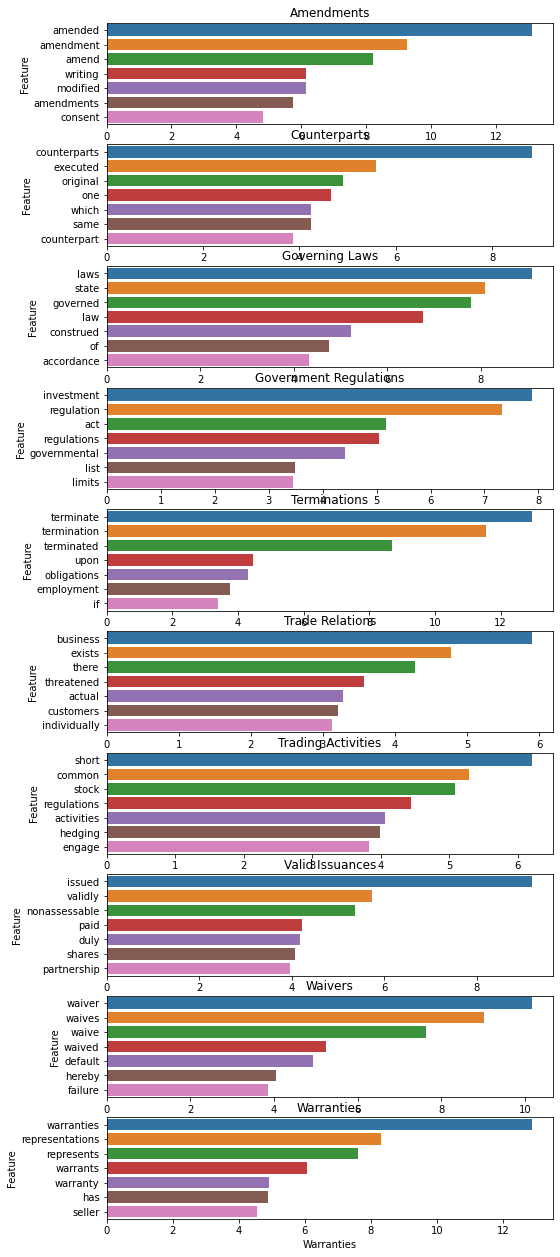

In [185]:
#Filter Feature Importance for Each Class
waivers_fi = df_feat_impts[["Feature", "Amendments"]].sort_values(by="Amendments", ascending=False).head(7)
gl_fi = df_feat_impts[["Feature", "Counterparts"]].sort_values(by="Counterparts", ascending=False).head(7)
amendments_fi = df_feat_impts[["Feature", "Governing Laws"]].sort_values(by="Governing Laws", ascending=False).head(7)
counterparts_fi = df_feat_impts[["Feature", "Government Regulations"]].sort_values(by="Government Regulations", ascending=False).head(7)
warranties_fi = df_feat_impts[["Feature", "Terminations"]].sort_values(by="Terminations", ascending=False).head(7)
terminations_fi = df_feat_impts[["Feature", "Trade Relations"]].sort_values(by="Trade Relations", ascending=False).head(7)
vi_fi = df_feat_impts[["Feature", "Trading Activities"]].sort_values(by="Trading Activities", ascending=False).head(7)
gr_fi = df_feat_impts[["Feature", "Valid Issuances"]].sort_values(by="Valid Issuances", ascending=False).head(7)
tr_fi = df_feat_impts[["Feature", "Waivers"]].sort_values(by="Waivers", ascending=False).head(7)
ta_fi = df_feat_impts[["Feature", "Warranties"]].sort_values(by="Warranties", ascending=False).head(7)

#Plot Feature Importance for Each Class
fix, ax = plt.subplots(10, 1, figsize=(10,22))
sns.barplot(y='Feature', x="Amendments", ax=ax[0], data=waivers_fi).set(title='Amendments')
sns.barplot(y='Feature', x="Counterparts", ax=ax[1], data=gl_fi).set(title='Counterparts')
sns.barplot(y='Feature', x="Governing Laws", ax=ax[2], data=amendments_fi).set(title='Governing Laws')
sns.barplot(y='Feature', x="Government Regulations", ax=ax[3], data=counterparts_fi).set(title='Government Regulations')
sns.barplot(y='Feature', x="Terminations", ax=ax[4], data=warranties_fi).set(title='Terminations')
sns.barplot(y='Feature', x="Trade Relations", ax=ax[5], data=terminations_fi).set(title='Trade Relations')
sns.barplot(y='Feature', x="Trading Activities", ax=ax[6], data=vi_fi).set(title='Trading Activities')
sns.barplot(y='Feature', x="Valid Issuances", ax=ax[7], data=gr_fi).set(title='Valid Issuances')
sns.barplot(y='Feature', x="Waivers", ax=ax[8], data=tr_fi).set(title='Waivers')
sns.barplot(y='Feature', x="Warranties", ax=ax[9], data=ta_fi).set(title='Warranties')
plt.show()

#### Hyperparameter Tuning
Even though our classification accuracy is high, it is good practice to explore hyperparameter tuning to see if we can achieve even better results. Below, we explore two hyperparameters to tune: <code>max_features</code> and the classifier <code>clf</code>. While we could be rigorous and perform a grid search based on permutations of the selected hyperparameters, we show a simpler example of selecting the optimal parameter stepwise. 

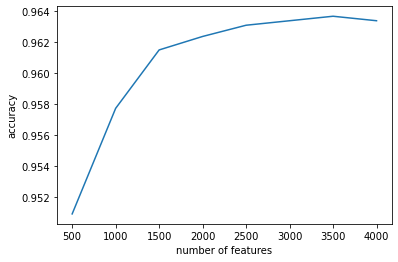

In [195]:
#Tune Number of Features (this code chunk takes about 2mins to run)
accuracy_feat = []
n_feat = range(500,4500,500)

for n in n_feat:
    vectorizer = TfidfVectorizer(max_features=n, ngram_range=(1, 1))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    clf.fit(X_train_vec, y_train)
    accuracy_feat.append(clf.score(X_test_vec, y_test))

plt.plot(n_feat, accuracy_feat)
plt.xlabel("number of features")
plt.ylabel("accuracy")
plt.show()

From the plot above, we can tell that the optimal number of features to use was about 3,500. This yields a slightly better accuracy of 0.96437, which is about 0.1% better than the earlier classifier.

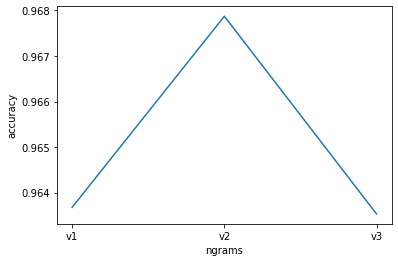

In [199]:
#Tune ngrams

#initialise TF-IDF model with optimal number of features but different ngram ranges
vectorizer1 = TfidfVectorizer(max_features=3500, ngram_range=(1, 1))
vectorizer2 = TfidfVectorizer(max_features=3500, ngram_range=(1, 2))
vectorizer3 = TfidfVectorizer(max_features=3500, ngram_range=(2, 2))

#store variables in arrays for iterating and plotting
vecs = [vectorizer1, vectorizer2, vectorizer3]
accuracy_vec = []

for v in vecs:
    X_train_vec = v.fit_transform(X_train)
    X_test_vec = v.transform(X_test)
    clf.fit(X_train_vec, y_train)
    accuracy_vec.append(clf.score(X_test_vec, y_test))

plt.plot(["v1", "v2", "v3"], accuracy_vec)
plt.xlabel("ngrams")
plt.ylabel("accuracy")
plt.show()

ngrams are another popular NLP method where several words are treated as a single phrase. Using more bigrams (or trigrams and beyond) usually lead to better classification performance because some phrases can have very different and significant and meanings and compared to their constituent words. However, they are computationally more expensive because there are almost twice (or 3x and beyond) as many words/phrases that can be formed. From the plot above, we observe that v2 (a mix of both monograms and bigrams) lead to the highest accuracy of about 0.96787, which is about 0.3% higher than the preceding classifier.

#### Conclusion
To sum up the work done in this notebook, we have analysed the dataset containing contract provisions and their labels, and created a multinomial classification model to predict the label of a contract given its provision. We explained the thinking behind our pre-processing and adopted the TF-IDF logistic model as our classifier. We also used various error metrics (ROC, accuracy, confusion matrix, F1-scores) to evaluate our model and critically examined the important features to assess if the model was sensible. Finally, we explored hyperparameter tuning to push up the classification accuracy of our model.

There are many ways where this NLP analysis could be improved:
 - <b>Hyperparameters:</b> there are still many hyperparameters left to tune, and a rigorous approach would do a grid search of $n \times n$ permutations for $n$ hyperparameters to find the globally optimal hyperparameter configuration.
 - <b>Memory and runtime constraints:</b> this analysis primarily considers accuracy as our main KPI. However, in practice, memory and runtime considerations should also be accounted for.
 - <b>Model selection:</b> It is customary to explore a range of classifiers before selecting the most optimal one. Here, we only consider the logistic model, but Naive Bayes has also been known to handle text processing well and was the staple algorithm for spam filtering in the past. Similarly, although we only used the TF-IDF approach here, there are also other NLP approaches which we could have adopted such as ngrams, other vectorisers, or string similarity analysis. 
 - <b>LLMs:</b> The hype of ChatGPT and BERT have made Large Language Models more prominent, and they have proven themselves to be extremely powerful tools. These models operate on the concept of embeddings, which are known to account for the semantic meaning of words far better than NLP approaches. As this exercise was designed to test my NLP aptitude, LLM approaches were not adopted. However, the author has some experience in this area and will be happy to discuss it further.

# <font color="blue">Part B</font>

## Guideline:

**STEP 1: DATA PREPARATION**  

- Download the CUAD dataset here: https://www.atticusprojectai.org/cuad
- Read the CUAD's [Datasheet](https://drive.google.com/drive/u/0/folders/1Yu-JnZj1LbVBfTdPiHfMDnaKZj4eqks8) and understand the format of the data.

**STEP 2: MODELLING**  
- Train a machine learning model to extract expiry date from a given plaintext contract. To account for model explainability, you may also train a model to first extract the relevant clause from a contract by outputting start and end tokens, and then extract the expiry date using a rule-based extractor. 
- Perform your own train-test split.
- Choose your own evaluation metrics and explain your choice(s)
- Feel feel to employ whichever modelling techniques you see fit, e.g. question answering, custom-NER, etc.
- We highly recommend you to read CUAD's paper on arxiv: [CUAD: An Expert-Annotated NLP Dataset for Legal Contract Review](https://arxiv.org/abs/2103.06268)

- You may refer to, and/or copy code blocks from any public Github repositories, Kaggle kernels or tutorials online. However, please add a comment indicating the source.
- You are free to conduct exploratory data analysis, write unit tests or any other additional steps as you find neccesary.
- The purpose is NOT to train the best-performing model. It is to help us assess your ability to learn and apply NLP modelling techniques.

## Answer:

In [ ]:
# Begin your code here


